In [ ]:
# checkpoint 10/27/18 
#  SINGLE SOMA works with Ina Ik Ica chi is the old version.
#  Icoup = 0.

In [1]:
from brian2 import *
from numpy import matlib
import numpy as np


In [5]:
start_scope()


# FUNCTION SECTION
zetap = 30.  # This is 40 in Poirazi paper
tempc = 23.*kelvin

ca = 2. # ca_out, unitless

xx = 0.0853*(273.16 + tempc/kelvin)/2  # kelvin
# xx = np.asarray(0.0853*(273.16 + tempc/kelvin)/2)  # kelvin
tadj = 2.3**((tempc/kelvin-23)/10)   
# unitless
q = 96480/(8.315*(273.16+tempc/kelvin))  
qt = 5**((tempc/kelvin-24)/10)  

qma = 0.000480*(1/ms)
qmb = 0.280000*(1/ms)
qhat = 1.



@implementation('cython',"""
def zeta(v):
    return -1.5-(1./(1.+exp((v+30.)/5.))) 
""")
@check_units(v=1, result=1)
def zeta(v):
    return -1.5-(1./(1.+exp((v+30.)/5.))) 
# zeta.stateless = True

@implementation('cython',"""
def zeta2(v):
    return -1.8-(1/(1+exp((v+40)/5)))  
""")
@check_units(v=1, result=1)
def zeta2(v):
    return -1.8-(1/(1+exp((v+40)/5)))  
# zeta2.stateless = True




# @implementation('cython',"""
# def eff(z):
#     return (1-z/2)*eff2(z)+(z/(exp(z)-1))*eff3(z) 
# """)
@implementation('numpy',discard_units=True)
@check_units(z=1, result=1)  # z is volt, so when used should do eff(z/mV). see ghk(volt)
def eff(z):
    return (1-z/2)*np.heaviside(0.0001-abs(z), 1)+(z/(exp(z)-1))*np.heaviside(abs(z)-0.0001, 1)  

#     return (1-z/2)*eff2(z)+(z/(exp(z)-1))*eff3(z)  

# @implementation('numpy')
# @check_units(z=1, result=1)  
# def eff2(z):
#     return np.heaviside(0.0001-abs(z), 1)  


# @implementation('numpy')
# @check_units(z=1, result=1)  
# def eff3(z):
#     return np.heaviside(abs(z)-0.0001, 1)  

# ,namespace = {'xx':0.0853*(273.16 + tempc/kelvin)/2, 'ca':2.}
# @implementation('cython', """
# def ghk(v,chi):
#     xx = 0.0853*(273.16 + tempc/kelvin)/2  # kelvin
#     ca = 2. # ca_out, unitless
#     return -xx*(1-((chi/ca)*exp(v/xx)))*eff(v/xx)  
# """,namespace = {'xx':xx, 'ca':2.})
# # namespace = {'xx':xx, 'ca':2.}
# @check_units(v=1, chi = 1, result=1)
# def ghk(v,chi):
#     return -xx*(1-((chi/ca)*exp(v/xx)))*eff(v/xx)  


@implementation('cython',"""
def salfa(v):
    return -0.055*(v+27.01)/(exp((-v-27.01)/3.8)-1) 
""")
@check_units(v=1, result=1)
def salfa(v):
    return -0.055*(v+27.01)/(exp((-v-27.01)/3.8)-1)  


@implementation('cython',"""
def sbeta(v):
    return 0.94*exp((-v-63.01)/17) 
""")
@check_units(v=1, result=1)
def sbeta(v):
    return 0.94*exp((-v-63.01)/17) 
# sbeta.stateless = True

t_st = 10*defaultclock.dt
# impulse_duration = period*1.1  # 1.25*ms
impulse_str = 62.5*uamp*cm**-2
period = 100*ms

@check_units(t=ms, result=1)
def frost(t):
    return (np.heaviside((t-t_st)/ms,0)*np.heaviside(sin(2*pi*(t-t_st-period)/period),1)\
            *np.heaviside(sin(2*pi*(t-t_st-period*1.4)/period),1))

In [6]:

# start_scope()


Ne = 1

# some calcium-related vars, table 2
pHC = 4.0*umolar
aHC = 0.6*umolar
pHN = 4.
aHN = 3.
alphav = 1.
alphab = 5.
alphad = 1.
thetav = 2.*umolar
thetad = 2.6
thetab = 0.55
Cp = 5.
Cd = 4.
taup = 500*ms
taua = 5*ms
tauv = 10*ms
taud = 250*ms
taub = 40*ms
sigmav = -0.05*umolar
sigmad = -0.01
sigmab = -0.02
p = 0.3
d = 0.01
kd = -0.002
kp = -0.1

# some calcium-related vars, concentration
phi = 0.01*umolar/ms/(uamp*cm**-2)
beta = 0.083/ms
chi0 = 0.05*umolar
nbuff = 6.*umolar



# E cells stats
Cme = 1*ufarad/cm**2
Ele = -67*mV
ENae = 50*mV
Ek = -100*mV
gle = 0.1*msiemens/cm**2
gKe = 80*msiemens/cm**2

# AMPA E-E
syn_mod = 1.

gampae = 0.05*syn_mod*msiemens/cm**2

# gampae = 0.00*syn_mod/(Ne-1)*msiemens/cm**2

#ggabae = 0.03*syn_mod/(Ni)*msiemens/cm**2


# NMDA (excitatory)
g_syn_nmda = 0.3*syn_mod*msiemens/cm**2
g_cal_nmda_0 = 25*syn_mod*msiemens/cm**2
# g_NMDA_I = 0.258 * nS * 800. / N_E
V_cal = 140*mV
tausnmdar = 1*ms
tausnmdad = 100*ms
# Mg2 = 1.
Mg2 = 2.

# Ileak 
glsoma = 0.1*msiemens/cm**2
El = -70.*mV

# Ina params
gNae = 30*msiemens/cm**2
naatt = 1.
taumna = 0.05*ms
# tauhna = 0.5*ms   # dendrite
tauhna = 1.*ms  # soma



# Ik params
gkdr = 14*msiemens/cm**2
taukdr = 3.5*ms

# Ia
ga = 7.5*msiemens/cm**2

# Imahp
gmahp = 25*msiemens/cm**2


# TEST
# Isyn = 0*amp*meter**-2
# Ileak = 0*amp*meter**-2
# I_cal_nmda = 0*amp*meter**-2
# Icoup = 0*amp*meter**-2
# gNae = 0*msiemens/cm**2
# # ga = 0*msiemens/cm**2
# gmahp = 0*msiemens/cm**2
# gkdr = 0*msiemens/cm**2
# E cells stats
Cme = 1*ufarad/cm**2
Ele = -67*mV
ENae = 50*mV
Ek = -100*mV
gle = 0.1*msiemens/cm**2
gKe = 80*msiemens/cm**2

# Ina
gNasoma = 30*msiemens/cm**2
ENa = 60*mV

# Ik
gkdrsoma = 14*msiemens/cm**2
gasoma = 7.5*msiemens/cm**2
gmahpsoma = 25*msiemens/cm**2
Ek = -80*mV
btaumod = 7.

# Ica
gcalsoma = 0.*uamp*cm**-2


# chi
phisoma = 0.01*umolar/ms/(uamp*cm**-2)



eqs_soma = '''
#dv/dt = ( ( Ileak   +Ica))/Cme : volt
dv/dt = ( ( Ileak +  Ina + Ik + Ica + Icoup + Iin))/Cme : volt


Ileak = glsoma * (El-v) : amp*meter**-2


Ina = gNasoma * mna**2 * hna * (ENa-v) : amp*meter**-2
# soma activation
alphams = 0.32*(-46.9-v/mV)/(exp((-46.9-v/mV)/4.0)-1.0)/ms :Hz
betams = 0.28*(v/mV+19.9)/(exp((v/mV+19.9)/5.0)-1.0)/ms :Hz
mna = alphams/(alphams+betams) : 1
dhna/dt=alphahs-(alphahs+betahs)*hna  :1
alphahs = 0.128*exp((-43.0-v/mV)/18.0)/ms :Hz
betahs = 4.0/(1.0+exp((-20.0-v/mV)/5.0))/ms :Hz



Ik = Ia + Ikdr + Imahp : amp*meter**-2

Ikdr = gkdrsoma * n_soma * (Ek - v) : amp*meter**-2
dn_soma/dt = alphans-(alphans+betans)*n_soma : 1 
alphans =  0.016*(-24.9-v/mV)/(exp((-24.9-v/mV)/5.0)-1.0)/ms : Hz  
betans =   0.25*exp(-1.0-0.025*v/mV)/ms  : Hz

Ia = gasoma * a_soma * b_soma * (Ek-v) : amp*meter**-2
da_soma/dt=(a_somainf-a_soma)/(a_somatau)  : 1
a_somainf=1/(1+a_smaalf)  : 1
a_smaalf=exp(0.001*zeta(v/mV)*(v/mV-11)*q)  : 1
a_smabet=exp(0.00055*q*(v/mV-11)*zeta(v/mV)) : 1
a_somatau=clip(a_smabet/((1+a_smaalf)*qt*0.05),0.1, inf)*ms : second
db_soma/dt=(b_somainf-b_soma)/(b_somatau) :1
b_somainf = 0.3+0.7/(1+exp(0.02*(v/mV+63.5)*q)) :1   
b_somatau = btaumod*clip(0.11*(v/mV+62),2,inf)*ms : second

Imahp = gmahpsoma * qm_soma * (Ek - v) : amp*meter**-2
dqm_soma/dt = (qm_smainf-qm_soma)/(qm_smatau)  :1
qm_smainf = qhat*qm_smaalf*qm_smatau  : 1
qm_smaalf = qma*chi/umolar/(0.001*chi/umolar + 0.18*exp(-1.68*v/mV*q)) : Hz 
qm_smabet = (qmb*exp(-0.022*v/mV*q))/(exp(-0.022*v/mV*q)+0.001*chi/umolar) : Hz  
qm_smatau = 1/(qm_smaalf+qm_smabet)  : second



Ica = -gcalsoma*s_soma*ghk*(1/(1+chi/umolar)) : amp*meter**-2
ghk = -xx*(1-((chi/umolar/ca)*exp(v/mV/xx)))*eff(v/mV/xx) :1
ds_soma/dt=(s_somainf-s_soma)/(s_somatau)  : 1
s_somainf=salfa(v/mV)/(salfa(v/mV)+sbeta(v/mV))  : 1
s_somatau=1/(5*(salfa(v/mV)+sbeta(v/mV)))*ms  : second

dchi/dt = phisoma*Ica - beta*(chi-chi0) -(beta/nbuff)*chi**2 : mmolar
dP/dt = ((10*(chi/pHC)**pHN / (1+(chi/pHC)**pHN))-Cp*A*P)/taup : 1
dA/dt = (((chi/aHC)**aHN/(1+(chi/aHC)**aHN))-A)/taua : 1
dV/dt = ( alphav/(1+exp((chi-thetav)/sigmav)) -V)/tauv : 1
dB/dt = ( alphab/(1+exp((A-thetab)/sigmab)) -B -Cd*V*B)/taub : 1
dD/dt = ( alphad/(1+exp((B-thetad)/sigmad)) -D)/taud : 1

'''
# dchi/dt = 0*mmolar/ms : mmolar



# Ia = gasoma * a_soma * b_soma * (Ek-v) : amp*meter**-2
# da_soma/dt=(a_somainf-a_soma)/(a_somatau)  : 1
# a_somainf=1/(1+a_smaalf)  : 1
# a_smaalf=exp(0.001*zeta(v/mV)*(v/mV-11)*q)  : 1
# a_smabet=exp(0.00055*q*(v/mV-11)*zeta(v/mV)) : 1
# a_somatau=clip(a_smabet/((1+a_smaalf)*qt*0.05),0.1, inf)*ms : second
# db_soma/dt=(b_somainf-b_soma)/(b_somatau) :1
# b_somainf = 0.3+0.7/(1+exp(0.02*(v/mV+63.5)*q)) :1   
# b_somatau = btaumod*clip(0.11*(v/mV+62),2,inf)*ms : second

Icoup = 0*amp*meter**-2
Iin = 1.0*uamp*cm**-2

# db_soma/dt=(b_somainf-b_soma)/(b_somatau) :1
# b_somainf = 0.3+0.7/(1+exp(0.02*(v/mV+63.5)*q)) :1   
# #b_somatau = btaumod*clip(0.11*(v/mV+62),2,inf)*ms : second
# b_somatau = 2*ms : second
    
Ecells = NeuronGroup(Ne, eqs_soma, threshold='v>0*mV',refractory='v > 0*mV',method='rk4')
Ecells.v = -50*mV
Ecells.chi = 0.05*umolar

#a_somatau = 0.2*ms# 
Me = StateMonitor(Ecells, {'v','chi'} , record=True)



In [7]:
duration = 20*ms
run(duration,report='stdout')

Starting simulation at t=0. s for a duration of 20. ms
0.02 (100%) simulated in < 1s


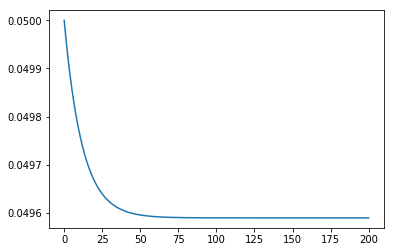

In [17]:
plot(Me.t/ms,Me[0].chi/umolar)
# plot(Me.t/ms,Me[0].v/mV)

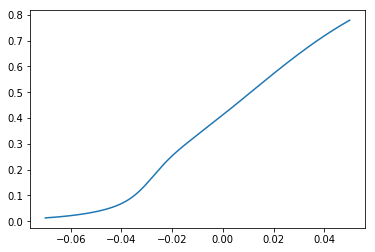

In [59]:
v= linspace(-70,50,1001)*mV
fv = exp(0.00055*q*(v/mV-11)*zeta(v))
#fv = 0.016*(-24.9-v/mV)/(exp((-24.9-v/mV)/5.0)-1.0)
fv2 = 1/(1+fv)
plot(v,fv2)

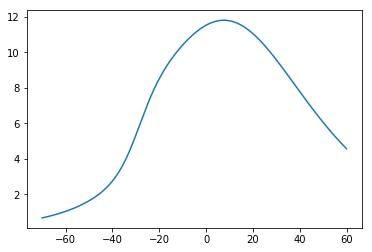

In [108]:
v= linspace(-70,60,1001)*mV
fv1=exp(0.001*zeta(v)*(v/mV-11)*q)  
fv2=exp(0.00055*q*(v/mV-11)*zeta(v))
# dfv=(fvinf-a_soma)/(a_somatau) 
zetav = zeta(v)
fvinf=1/(1+fv1) 
fvtau=np.maximum(fv2/((1+fv1)*qt*0.05),0.1*np.ones(1001))
plot(v/mV,fvtau)
# xlim(-60,-40)
# ylim(0,0.01)

In [67]:
fv2/((1+fv1)*qt*0.05)-0.1*np.ones(1001)

array([0.56142975, 0.56494181, 0.56847265, ..., 5.98774474, 5.96814279,
       5.94857873])

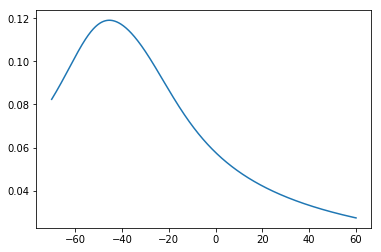

In [107]:
v= linspace(-70,60,1001)*mV

alpham = (0.32/mV) * (v+54*mV) / (-exp((-v-54*mV) / (4*mV)) + 1) 
betam = (0.28/mV) * (v+27*mV)/ (exp((v+27*mV)/(5*mV)) - 1)
taum = 1/(alpham+betam)
minf = alpham*taum

plot(v/mV,taum)

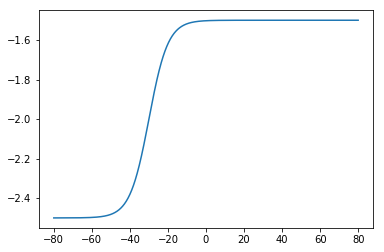

In [8]:
v= linspace(-80,80,1001)*mV


zetav = zeta(v/mV)
plot(v/mV,zetav)

In [25]:
np.heaviside(1,1)

1.0